# Evaluating the model on clean and adversarial examples

In [2]:
import polars as pl
from tqdm import tqdm
from pathlib import Path
from csv import DictWriter
from operator import itemgetter

In [3]:
%pip freeze

absl-py==2.1.0
accelerate==1.4.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
altair==5.5.0
anyio==4.8.0
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
arrow==1.3.0
asttokens==3.0.0
astunparse==1.6.3
async-lru==2.0.4
attrs==25.1.0
babel==2.17.0
beautifulsoup4==4.13.0
bleach==6.2.0
certifi==2025.1.31
cffi==1.17.1
charset-normalizer==3.4.1
cleverhans==4.0.0
cloudpickle==3.1.1
comm==0.2.2
contourpy==1.3.1
cycler==0.12.1
datasets==3.3.1
debugpy==1.8.12
decorator==5.1.1
defusedxml==0.7.1
dill==0.3.8
dm-tree==0.1.9
easydict==1.13
evaluate==0.4.3
executing==2.2.0
fastjsonschema==2.21.1
filelock==3.17.0
flatbuffers==25.1.24
fonttools==4.55.8
fqdn==1.5.1
frozenlist==1.5.0
fsspec==2024.9.0
gast==0.6.0
google-pasta==0.2.0
grpcio==1.70.0
h11==0.14.0
h5py==3.12.1
httpcore==1.0.7
httpx==0.28.1
huggingface-hub==0.28.1
idna==3.10
imbalanced-learn==0.13.0
imblearn==0.0
ipykernel==6.29.5
ipython==8.32.0
ipywidgets==8.1.5
isoduration==20.11.0
jedi==0.19.2
Jinja2==3.1.5
joblib==1.4.2
json5=

In [4]:
pl.show_versions()

--------Version info---------
Polars:              1.25.0
Index type:          UInt32
Platform:            Linux-4.18.0-553.34.1.el8_10.x86_64-x86_64-with-glibc2.28
Python:              3.12.8 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:31:09) [GCC 11.2.0]
LTS CPU:             False

----Optional dependencies----
<not installed>      
<not installed>ager  
5.5.0r               
<not installed>      
<not installed>      
3.1.1pickle          
<not installed>      
<not installed>      
<not installed>      
2024.9.0             
<not installed>      
<not installed>      
<not installed>      
3.10.0tlib           
2.0.2                
<not installed>      
2.2.3s               
<not installed>      
19.0.0w              
<not installed>      
<not installed>      
<not installed>      
2.6.0+cu124          
<not installed>      
<not installed>      


## Naively count all correct predictions of adversarial datasets

In [10]:
true_labels = pl.col('identifier').str.extract(r"(\w+)_\d+\.jpg").str.to_titlecase().alias('true label')

In [11]:
l1_predictions_path = '/home/gscalubayan/cs199/huggingfacevit/fgsm_l1.csv'
l2_predictions_path = '/home/gscalubayan/cs199/huggingfacevit/fgsm_l2.csv'
linf_predictions_path = '/home/gscalubayan/cs199/huggingfacevit/fgsm_linf.csv'
baseline_predictions_path = '/home/gscalubayan/cs199/huggingfacevit/baseline.csv'

In [12]:
def labels_to_enum(path_to_preds):
    temp = pl.scan_csv(path_to_preds).with_columns(true_labels).collect()
    df = temp.cast({ 'label': pl.Enum(['Real', 'Fake']) }).cast({ 'true label': pl.Enum(['Real', 'Fake']) })
    return df

In [13]:
l1_pred_df = labels_to_enum(l1_predictions_path)
l1_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Fake""",0.999539,"""Dataset/Test/Fake/fake_0.jpg""","""Fake"""
"""Fake""",0.999098,"""Dataset/Test/Fake/fake_1.jpg""","""Fake"""
"""Fake""",0.999396,"""Dataset/Test/Fake/fake_10.jpg""","""Fake"""
"""Fake""",0.999096,"""Dataset/Test/Fake/fake_100.jpg""","""Fake"""
"""Fake""",0.999609,"""Dataset/Test/Fake/fake_1000.jp…","""Fake"""


In [14]:
l2_pred_df = labels_to_enum(l2_predictions_path)
l2_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Fake""",0.999522,"""Dataset/Test/Fake/fake_0.jpg""","""Fake"""
"""Fake""",0.998887,"""Dataset/Test/Fake/fake_1.jpg""","""Fake"""
"""Fake""",0.999344,"""Dataset/Test/Fake/fake_10.jpg""","""Fake"""
"""Fake""",0.998818,"""Dataset/Test/Fake/fake_100.jpg""","""Fake"""
"""Fake""",0.999602,"""Dataset/Test/Fake/fake_1000.jp…","""Fake"""


In [15]:
linf_pred_df = labels_to_enum(linf_predictions_path)
linf_pred_df.head()

label,score,identifier,true label
enum,f64,str,enum
"""Real""",0.994812,"""Dataset/Test/Fake/fake_0.jpg""","""Fake"""
"""Real""",0.995383,"""Dataset/Test/Fake/fake_1.jpg""","""Fake"""
"""Real""",0.998019,"""Dataset/Test/Fake/fake_10.jpg""","""Fake"""
"""Real""",0.971443,"""Dataset/Test/Fake/fake_100.jpg""","""Fake"""
"""Real""",0.750671,"""Dataset/Test/Fake/fake_1000.jp…","""Fake"""


In [16]:
from sklearn.metrics import accuracy_score
def get_accuracy(df, test):
    acc = accuracy_score(df['true label'], df['label'])
    num_correct = accuracy_score(df['true label'], df['label'], normalize=False)
    print(f'{test} accuracy = {acc}, {num_correct} correct predictions out of {df.height}')

get_accuracy(l1_pred_df, 'FGSM L1')
get_accuracy(l2_pred_df, 'FGSM L2')
get_accuracy(linf_pred_df, 'FGSM Linf')

FGSM L1 accuracy = 0.9923818530485723, 188885.0 correct predictions out of 190335
FGSM L2 accuracy = 0.989634066251609, 188362.0 correct predictions out of 190335
FGSM Linf accuracy = 0.1979930123203825, 37685.0 correct predictions out of 190335


## Prepare datasets for sampling

In [17]:
def create_data_dict(data_path):
    return {
        'image': [str(file) for file in data_path],
        'label': [file.parts[-2] for file in data_path],
        'identifier': ['/'.join(file.parts[4::]) for file in data_path]
    }

In [18]:
# Prepare datasets
original_dataset_path = sorted(Path('/home/gscalubayan/dataset_extract/Dataset').glob('*/*/*.*'))
adversarial_l1_data_path = sorted(Path('/home/gscalubayan/cs199/huggingfacevit/adversarial/fgsm_l1/Dataset').glob('*/*/*.*'))
adversarial_l2_data_path = sorted(Path('/home/gscalubayan/cs199/huggingfacevit/adversarial/fgsm_l2/Dataset').glob('*/*/*.*'))
adversarial_linf_data_path = sorted(Path('/home/gscalubayan/cs199/huggingfacevit/adversarial/fgsm_linf/Dataset').glob('*/*/*.*'))

In [19]:
from datasets import Image, Dataset as HuggingFaceDataset

In [20]:
original_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(original_dataset_path))
    .cast_column('image', Image())
)
original_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=256x256>,
 'label': 'Fake',
 'identifier': 'Dataset/Test/Fake/fake_0.jpg'}

In [21]:
adversarial_l1_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_l1_data_path))
    .cast_column('image', Image())
)
adversarial_l1_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_l1/Dataset/Test/Fake/fake_0.jpg'}

In [22]:
adversarial_l2_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_l2_data_path))
    .cast_column('image', Image())
)
adversarial_l2_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_l2/Dataset/Test/Fake/fake_0.jpg'}

In [23]:
adversarial_linf_ds = (
    HuggingFaceDataset
    .from_dict(create_data_dict(adversarial_linf_data_path))
    .cast_column('image', Image())
)
adversarial_linf_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=224x224>,
 'label': 'Fake',
 'identifier': 'huggingfacevit/adversarial/fgsm_linf/Dataset/Test/Fake/fake_0.jpg'}

Dataset/Test/Fake/fake_2200.jpg Fake


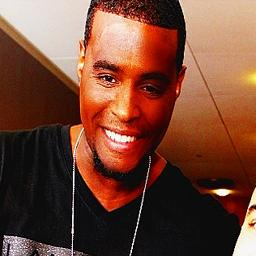

In [24]:
# View a random image
index = 1337

item = original_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_l1/Dataset/Test/Fake/fake_2200.jpg Fake


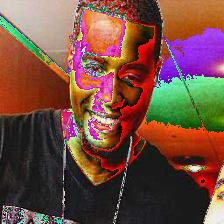

In [25]:
# View a random adversarial FGSM-L1 image
item = adversarial_l1_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_l2/Dataset/Test/Fake/fake_2200.jpg Fake


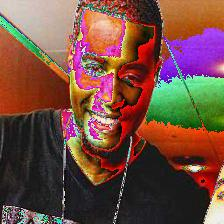

In [26]:
# View a random adversarial FGSM-L2 image
item = adversarial_l2_ds[index]
print(item['identifier'], item['label'])
item['image']

huggingfacevit/adversarial/fgsm_linf/Dataset/Test/Fake/fake_2200.jpg Fake


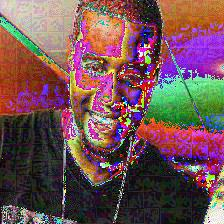

In [27]:
# View a random adversarial FGSM-L-inf image
item = adversarial_linf_ds[index]
print(item['identifier'], item['label'])
item['image']

In [28]:
# Prepare model pipeline
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset
model_str = "dima806/deepfake_vs_real_image_detection"
classifier = pipeline('image-classification', model_str, device='cuda')

Device set to use cuda


In [23]:
# Evaluate original model on "clean" dataset
with open('/home/gscalubayan/cs199/huggingfacevit/baseline.csv', 'w', newline='') as csvfile:
    fieldnames = ['label', 'score', 'identifier']
    writer = DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    results = classifier(KeyDataset(original_ds, 'image'))
    for result, ident in tqdm(zip(results, original_ds['identifier'])):
        writer.writerow(max(({ 'label': res['label'], 'score': res['score'], 'identifier': ident } for res in result), key=itemgetter('score')))

190335it [28:30, 111.26it/s]


In [29]:
base_pred_df = labels_to_enum(baseline_predictions_path)
get_accuracy(base_pred_df, 'baseline')

baseline accuracy = 0.9924396458875141, 188896.0 correct predictions out of 190335


# Sample and evaluate on original and adversarial datasets

In [30]:
base_samples_path = '/home/gscalubayan/cs199/huggingfacevit/samples_original/sample'
l1_samples_path = '/home/gscalubayan/cs199/huggingfacevit/samples_fgsm_l1/adv-sample'
l2_samples_path = '/home/gscalubayan/cs199/huggingfacevit/samples_fgsm_l2/adv-sample'
linf_samples_path = '/home/gscalubayan/cs199/huggingfacevit/samples_fgsm_linf/adv-sample'

csv_write_paths = [base_samples_path, l1_samples_path, l2_samples_path, linf_samples_path]
hf_datasets = [original_ds, adversarial_l1_ds, adversarial_l2_ds, adversarial_linf_ds]

In [31]:
# Generate 50 samples with 1000 images for each dataset
for path, ds in zip(csv_write_paths, hf_datasets):
    for i in tqdm(range(1,51)):
        sample = ds.train_test_split(test_size=1000, seed=i)['test']
        save_location = f'{path}{i}.csv'
        save_dir = Path(save_location).parent  # Get the directory of the save location
        save_dir.mkdir(parents=True, exist_ok=True)  # Create any missing directories
        with open(save_location, 'w', newline='') as csvfile:
            fieldnames = ['label', 'score', 'identifier']
            writer = DictWriter(csvfile, fieldnames=fieldnames)
            writer.writeheader()
            results = classifier(KeyDataset(sample, 'image'))
            for result, ident in zip(results, sample['identifier']):
                writer.writerow(max(({ 'label': res['label'], 'score': res['score'], 'identifier': ident } for res in result), key=itemgetter('score')))

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset,  9.44s/it]
100%|███████████████████████████████████████████████████████████████████████████████████| 50/50 [07:03<00:00,  8.47s/it]


## Statistical analysis

In [36]:
# Count number of wrong predictions

def get_error_counts(path: str):
    error_counts = []
    for i in range(1,51):
        sample = pl.scan_csv(f'{path}{i}.csv').with_columns(true_labels).collect()
        isCorrect_df = (sample['label'] == sample['true label']).value_counts()
        error_counts.append(isCorrect_df.filter(pl.col('label') == pl.lit(False)).select('count').item())
    return error_counts

In [37]:
errors_dict = { 'datasets': ['baseline', 'L1', 'L2', 'L-inf'], 'error_counts': [] }

for path in csv_write_paths:
    errors_dict['error_counts'].append(get_error_counts(path))

errors = pl.from_dict(errors_dict)
errors.head()

datasets,error_counts
str,list[i64]
"""baseline""","[8, 5, … 9]"
"""L1""","[188, 198, … 204]"
"""L2""","[225, 238, … 245]"
"""L-inf""","[536, 557, … 530]"


In [38]:
error_dict_columns = {}

for i in range(errors.height):
    curr_ds = errors[i].select('datasets').item()
    curr_ds_error_counts = errors[i].select('error_counts').item()
    print(curr_ds_error_counts.describe())
    error_dict_columns[curr_ds] = curr_ds_error_counts

shape: (9, 2)
┌────────────┬─────────┐
│ statistic  ┆ value   │
│ ---        ┆ ---     │
│ str        ┆ f64     │
╞════════════╪═════════╡
│ count      ┆ 50.0    │
│ null_count ┆ 0.0     │
│ mean       ┆ 7.52    │
│ std        ┆ 2.56539 │
│ min        ┆ 4.0     │
│ 25%        ┆ 6.0     │
│ 50%        ┆ 7.0     │
│ 75%        ┆ 9.0     │
│ max        ┆ 15.0    │
└────────────┴─────────┘
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 50.0      │
│ null_count ┆ 0.0       │
│ mean       ┆ 196.5     │
│ std        ┆ 10.738544 │
│ min        ┆ 170.0     │
│ 25%        ┆ 190.0     │
│ 50%        ┆ 197.0     │
│ 75%        ┆ 202.0     │
│ max        ┆ 224.0     │
└────────────┴───────────┘
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 50.0      │
│ null_count ┆ 0

In [39]:
errors_exploded = errors.explode('error_counts')
errors_exploded.head()

datasets,error_counts
str,i64
"""baseline""",8
"""baseline""",5
"""baseline""",7
"""baseline""",8
"""baseline""",7


In [72]:
import altair as alt
import matplotlib.pyplot as plt

#errors_exploded.hist(column='error_counts', by='datasets', bins=100)

# Create an Altair histogram
alt.Chart(errors_exploded).mark_bar(opacity=0.7).encode(
    x=alt.X("error_counts:Q", bin=alt.Bin(maxbins=100)),  # Histogram binning
    y="count()",  # Frequency count
    color="datasets:N"  # Different colors for each dataset
).properties(
    width=800,  # Increase chart width
    height=400  # Adjust height if needed
).interactive()

alt.Chart(...)

In [50]:
errors_hists = pl.from_dict(error_dict_columns)
errors_hists.head()

baseline,L1,L2,L-inf
i64,i64,i64,i64
8,188,225,536
5,198,238,557
7,190,232,526
8,200,247,550
7,215,255,563


In [51]:
from scipy import stats

In [73]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['baseline']).pvalue}")
# errors_hists.plot.hist('baseline', bins=10)

# Altair histogram
alt.Chart(errors_hists).mark_bar().encode(
    x=alt.X("baseline:Q", bin=alt.Bin(maxbins=10)),  # Bin the baseline values
    y="count()"
).properties(
    width=800,  # Increase chart width
    height=400  # Adjust height if needed
).interactive()

Shapiro-Wilk normality test p-val=0.008575529348051855


alt.Chart(...)

In [74]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L1']).pvalue}")
#errors_hists.plot.hist('L1', bins=10)

# Altair histogram
alt.Chart(errors_hists).mark_bar().encode(
    x=alt.X("L1:Q", bin=alt.Bin(maxbins=10)),  # Bin the L1 values
    y="count()"
).properties(
    width=800,  # Increase chart width
    height=400  # Adjust height if needed
).interactive()

Shapiro-Wilk normality test p-val=0.6573908835765937


alt.Chart(...)

In [75]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L2']).pvalue}")
#errors_hists.plot.hist('L2', bins=10)

# Altair histogram
alt.Chart(errors_hists).mark_bar().encode(
    x=alt.X("L2:Q", bin=alt.Bin(maxbins=10)),  # Bin the L2 values
    y="count()"
).properties(
    width=800,  # Increase chart width
    height=400  # Adjust height if needed
).interactive()

Shapiro-Wilk normality test p-val=0.4719359928953153


alt.Chart(...)

In [76]:
print(f"Shapiro-Wilk normality test p-val={stats.shapiro(errors_hists['L-inf']).pvalue}")
#errors_hists.plot.hist('L-inf', bins=10)

# Altair histogram
alt.Chart(errors_hists).mark_bar().encode(
    x=alt.X("L-inf:Q", bin=alt.Bin(maxbins=10)),  # Bin the L-inf values
    y="count()"
).properties(
    width=800,  # Increase chart width
    height=400  # Adjust height if needed
).interactive()

Shapiro-Wilk normality test p-val=0.701262893962395


alt.Chart(...)